# EDA - Nivel 2

## Nivel 2: Ingeniería y Preparación de Datos

En este nivel, subimos la dificultad. Ya no solo miramos los datos, sino que los **preparamos** para que un modelo de Machine Learning pueda entenderlos. Nos enfrentaremos a problemas del mundo real como datos sucios ocultos y variables que necesitan transformación.

Nos enfocaremos en las siguientes etapas:

- **Detección de "Trampas":** Identificar columnas que parecen correctas pero tienen errores ocultos.
- **Baseline Accuracy:** Entender el desbalance de clases (¿qué pasa si mi modelo dice siempre "No"?).
- **Feature Engineering:** Crear nuevas variables (bins) para mejorar la predicción.
- **Encoding:** Traducir texto a números (One-Hot Encoding) para los algoritmos.
- **Correlación:** Medir matemáticamente la relación entre variables.

Para este ejemplo usaremos el dataset **Telco Customer Churn**, que contiene información sobre clientes de una empresa de telecomunicaciones y si cancelaron su servicio (Churn).

Fuente: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

# 1. CARGA DE DATOS

In [20]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [21]:
# Importamos el dataset

base_dir = Path.cwd()
csv_file_path = base_dir.parent.parent.parent / "data" / "telco_customer_churn" / "Telco-Customer-Churn.csv"
df = pd.read_csv(csv_file_path, low_memory=False)

# Mostramos la primera fila del DataFrame para verificar que se ha cargado correctamente
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


# 2. LIMPIEZA DE TIPOS DE DATOS
### Objetivo
Comprender el resultado de `.info()` 

#### El Problema
A primera vista, todas las columnas parecen estar bien. Pero hay una "trampa" común en este dataset.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


> **Observación:** Fíjate en la columna `TotalCharges`. Aparece como `object` (texto), pero debería ser numérica (float). Esto sucede porque contiene espacios vacíos `" "` que pandas interpreta como texto.

In [23]:
# Forzamos la conversión a numérico. 'coerce' convierte los errores (espacios) en NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificamos cuántos nulos se generaron
print(f"Valores nulos en TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Imputamos los nulos con la mediana (es más robusta a outliers que la media)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

Valores nulos en TotalCharges: 11


# 3. ANÁLISIS DEL DESBALANCE DE CLASES
### Objetivo
Entender que en la vida real, los casos positivos (ej. fraude, fuga) suelen ser la minoría.

#### Baseline Accuracy
Si asumimos que nadie se va (predicimos siempre "No Churn"), ¿qué tan precisos seríamos?

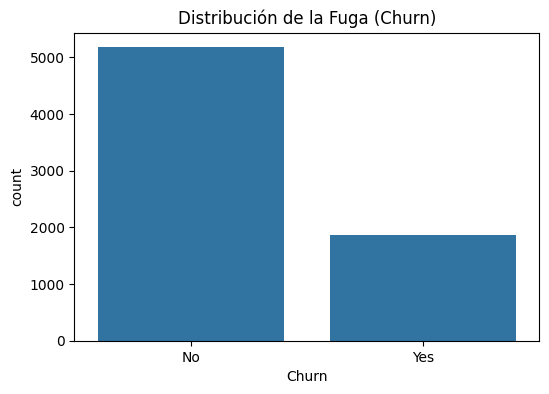

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de la Fuga (Churn)')
plt.show()

# Calculamos el porcentaje exacto
print(df['Churn'].value_counts(normalize=True) * 100)

> **Análisis:**
> 
> - Vemos que aproximadamente el **73%** de los clientes NO se van (Clase Mayoritaria).
> - **¿Qué significa este 73%?** Es nuestro **Baseline Accuracy** (Línea Base).
>   - Imagina un "modelo dummy" que simplemente adivina que *ningún* cliente se irá. Este modelo acertaría el 73% de las veces sin saber nada.
>   - Por lo tanto, **cualquier modelo de Machine Learning que construyamos debe tener una precisión SUPERIOR al 73%** para que valga la pena. Si nuestro modelo tiene 70% de accuracy, es peor que no hacer nada.

# 4. ANÁLISIS BIVARIADO CATEGÓRICO (INSIGHTS DE NEGOCIO)
### Objetivo
Ver cómo las categorías afectan la fuga. Responderemos preguntas de negocio clave.

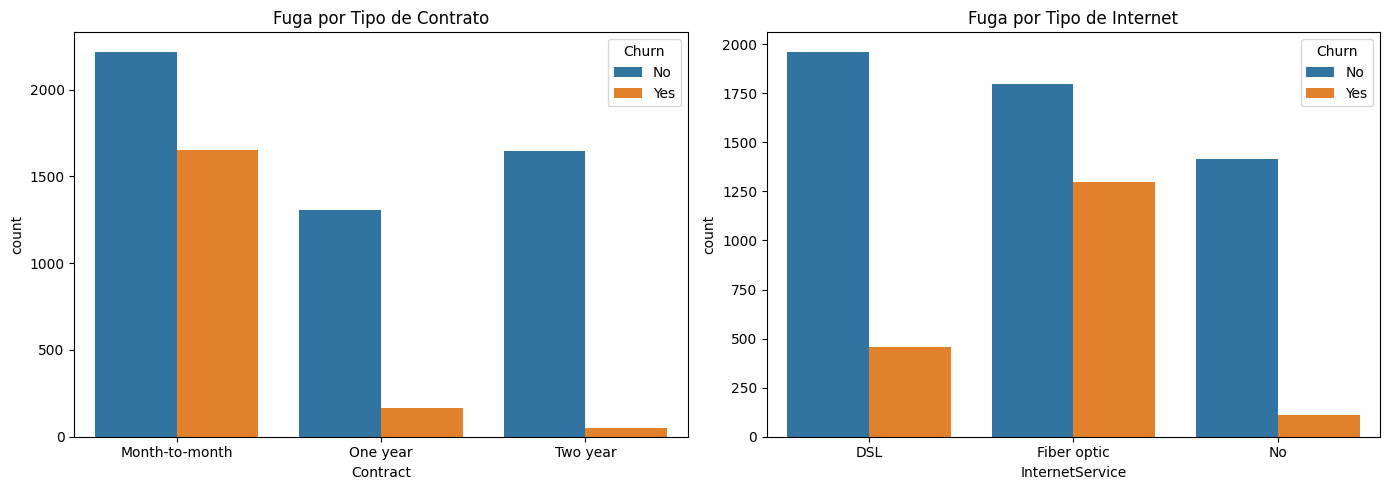

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contrato vs Churn
sns.countplot(x='Contract', hue='Churn', data=df, ax=axes[0])
axes[0].set_title('Fuga por Tipo de Contrato')

# Servicio de Internet vs Churn
sns.countplot(x='InternetService', hue='Churn', data=df, ax=axes[1])
axes[1].set_title('Fuga por Tipo de Internet')

plt.tight_layout()
plt.show()

> **Insights:**
> 
> - **Contrato:** Los clientes con contrato "Month-to-month" tienen una tasa de fuga altísima comparada con los de "Two year".
> - **Internet:** Los usuarios de "Fiber optic" tienden a irse más que los de "DSL". Esto podría indicar problemas de calidad o precio en el servicio de fibra.

# 5. FEATURE ENGINEERING (CREACIÓN DE VARIABLES)
### Objetivo
Crear nueva información a partir de la existente para ayudar al modelo.

#### Binning (Agrupación)
La variable `tenure` (meses de permanencia) es numérica. A veces el comportamiento de los clientes se entiende mejor por grupos (Nuevos vs Leales).

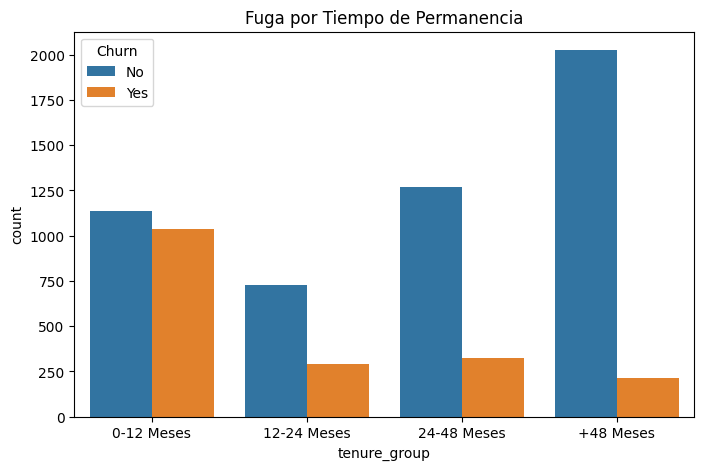

In [26]:
# Definimos los rangos (bins) y las etiquetas
bins = [0, 12, 24, 48, 100]
labels = ['0-12 Meses', '12-24 Meses', '24-48 Meses', '+48 Meses']

# Creamos la nueva columna
df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels)

# Visualizamos la fuga por grupo de permanencia
plt.figure(figsize=(8, 5))
sns.countplot(x='tenure_group', hue='Churn', data=df)
plt.title('Fuga por Tiempo de Permanencia')
plt.show()

# 6. CODIFICACIÓN DE VARIABLES (ENCODING)
### Objetivo
Transformar texto a números, ya que los modelos de ML no entienden "Yes", "No", "Male", "Female".

#### Estrategia

1.  **Binarios (2 opciones):** Mapeo directo a 0 y 1.
2.  **Nominales (>2 opciones):** One-Hot Encoding (crear columnas dummy).

In [27]:
# 1. Variables Binarias Manuales
# Primero verificamos que no haya nulos en estas columnas
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    print(f"Valores únicos en {col}: {df[col].unique()}")

df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Valores únicos en gender: ['Female' 'Male']
Valores únicos en Partner: ['Yes' 'No']
Valores únicos en Dependents: ['No' 'Yes']
Valores únicos en PhoneService: ['No' 'Yes']
Valores únicos en PaperlessBilling: ['Yes' 'No']
Valores únicos en Churn: ['No' 'Yes']


### ¿Qué es One-Hot Encoding?
Para variables con más de 2 opciones (como `InternetService`: DSL, Fiber optic, No), no podemos simplemente asignarles números 1, 2, 3.
¿Por qué? Porque el modelo pensaría que 3 es "mayor" que 1, y eso no es cierto (la fibra óptica no es "mayor" que el DSL, es solo diferente).

**Solución:** Creamos una nueva columna para cada opción posible.

- `InternetService_DSL` (1 si es DSL, 0 si no)
- `InternetService_Fiber optic` (1 si es Fibra, 0 si no)
... y así sucesivamente.

In [28]:
# 2. One-Hot Encoding para el resto
# Seleccionamos las columnas categóricas restantes (excluyendo las que ya convertimos o no sirven como customerID)
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaymentMethod', 'tenure_group']

# pd.get_dummies crea las nuevas columnas (drop_first=True evita la multicolinealidad)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Eliminamos customerID que no aporta valor predictivo
if 'customerID' in df_encoded.columns:
    df_encoded.drop(columns=['customerID'], inplace=True)

print(f"Dimensiones originales: {df.shape}")
print(f"Dimensiones después del Encoding: {df_encoded.shape}")
df_encoded.head(3)

Dimensiones originales: (7043, 22)
Dimensiones después del Encoding: (7043, 34)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_12-24 Meses,tenure_group_24-48 Meses,tenure_group_+48 Meses
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,True,False,False,False,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,True,False,False,False,True,False,True,False
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,True,False,False,False


In [29]:
# Verificamos los tipos de datos resultantes
df_encoded.dtypes.value_counts()

bool       24
int64       8
float64     2
Name: count, dtype: int64

In [30]:
# Luego del procesamiento tenemos valores boolean que para efectos prácticos
# pueden ser tratados como enteros 0/1 por el proceso de entrenamiento.
# Sin embargo es mejor convertirlos explícitamente a int para evitar problemas de tipo de datos en el modelo.
# Seleccionamos todas las columnas bool
bool_cols = df_encoded.select_dtypes(include="bool").columns

# Convertimos a int (0/1)
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Visualizamos nuevamente los tipos de datos
df_encoded.dtypes.value_counts()

int64      32
float64     2
Name: count, dtype: int64

# 7. MATRIZ DE CORRELACIÓN
### Objetivo
Ver relaciones matemáticas ahora que todo es numérico.

Top Correlaciones Positivas:
 Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling                  0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
tenure_group_12-24 Meses          0.020308
Name: Churn, dtype: float64

Top Correlaciones Negativas:
 TechSupport_No internet service   -0.227890
StreamingTV_No internet service   -0.227890
tenure_group_+48 Meses            -0.263222
Contract_Two year                 -0.302253
tenure                            -0.352229
Name: Churn, dtype: float64


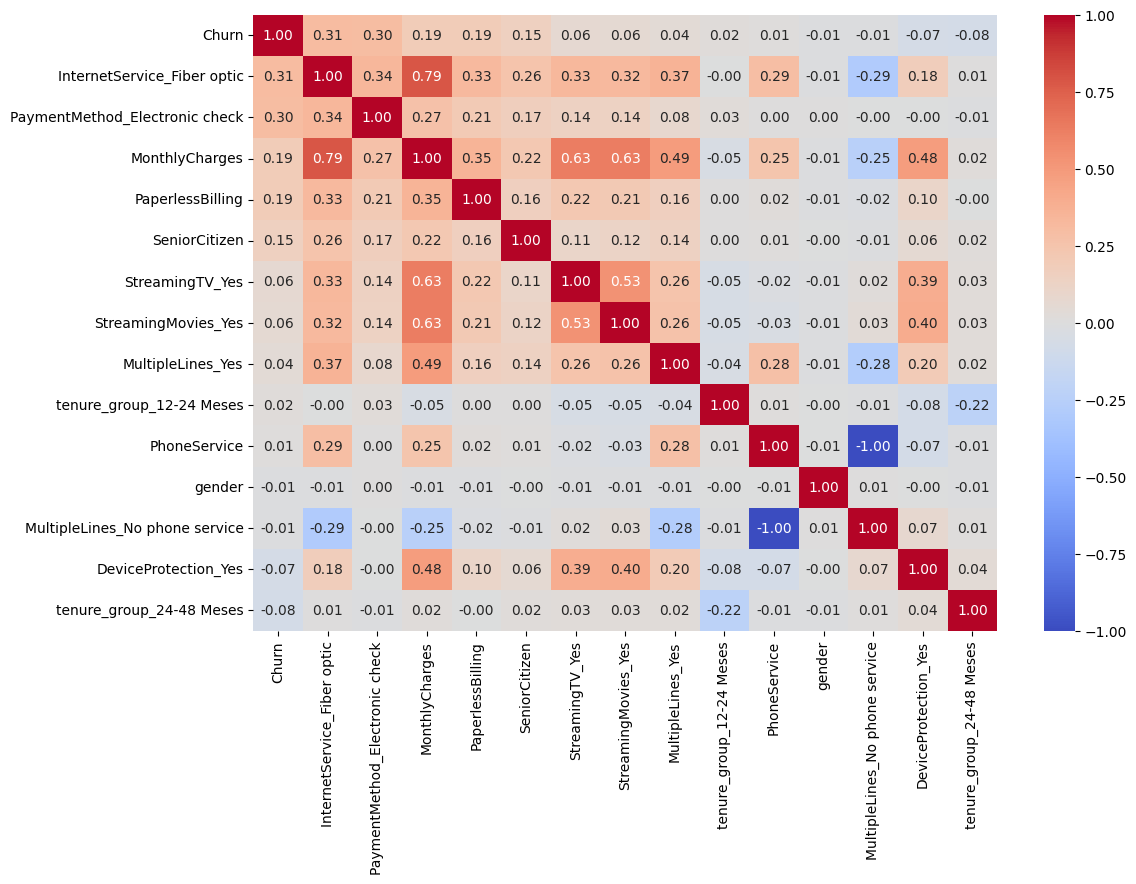

In [31]:
plt.figure(figsize=(12, 8))
# Calculamos la correlación con la variable objetivo 'Churn'
corr_churn = df_encoded.corr()['Churn'].sort_values(ascending=False)

# Mostramos las 10 variables más correlacionadas positivamente y las 5 más negativas
print("Top Correlaciones Positivas:\n", corr_churn.head(10))
print("\nTop Correlaciones Negativas:\n", corr_churn.tail(5))

# Heatmap de las variables más importantes (opcional, para no saturar el gráfico)
top_cols = corr_churn.index[:15] # Las 15 más altas
sns.heatmap(df_encoded[top_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# 8. CONCLUSIONES Y SIGUIENTES PASOS
### Resumen

1.  **Limpieza:** Descubrimos que `TotalCharges` tenía espacios vacíos y los corregimos.
2.  **Insights:** 
    *   Los contratos mensuales y la fibra óptica son factores de riesgo de fuga.
    *   Los clientes nuevos (0-12 meses) son los más propensos a irse.
3.  **Preparación:** Hemos convertido todo a números. El dataset pasó de ~20 columnas a más de 30 debido al One-Hot Encoding.

### Reflexión para Nivel 3
El One-Hot Encoding es útil, pero... ¿qué pasaría si tuviéramos una columna como "Código Postal" con 500 categorías? Nuestro dataset crecería enormemente (High Cardinality).